# Imports and Downloads

In [1]:
# download dependencies if needed
%pip install pandas numpy scikit-learn torch --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 787.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import os
from os import walk

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

import torch
import torchvision
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F

from torch import nn
from torchvision.transforms import ToTensor
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.utils.data.dataset import random_split

from PIL import Image
from sklearn.preprocessing import LabelEncoder

# Import and Process Data

In [5]:
train_img_path = './images/train/'
test_img_path = './images/test/'

# Dataframes
train_df = pd.read_csv('fairface_label_train.csv')
test_df = pd.read_csv('fairface_label_test.csv')

In [6]:
# Remove service_test column (unused: see issue https://github.com/joojs/fairface/issues/9)
# train_df = train_df.drop('service_test', axis=1)
# test_df = test_df.drop('service_test', axis=1)


# Encode age, gender, and race
#    and keep map for each: {encoded_label: actual_label}
le = LabelEncoder()

age_encoded = le.fit_transform(train_df['age'])
train_df['age_encoded'] = age_encoded
age_map = {i: l for i, l in enumerate(le.classes_)}
age_encoded = le.fit_transform(test_df['age'])
test_df['age_encoded'] = age_encoded

gender_encoded = le.fit_transform(train_df['gender'])
train_df['gender_encoded'] = gender_encoded
gender_map = {i: l for i, l in enumerate(le.classes_)}
gender_encoded = le.fit_transform(test_df['gender'])
test_df['gender_encoded'] = gender_encoded

# Assign each picture one class: age gender
label_map = {}
for gender_key, gender_value in gender_map.items():
    for age_key, age_value in age_map.items():
        label_key = age_key + gender_key * len(age_map)
        label_value = f'{age_value} {gender_value}'
        label_map[label_key] = label_value
train_df['label'] = train_df['age_encoded'] + train_df['gender_encoded'] * len(age_map)
test_df['label'] = test_df['age_encoded'] + test_df['gender_encoded'] * len(age_map)

# Sample data from train_df
train_df.head()

,file,age,gender,race,service_test,age_encoded,gender_encoded,label
0,train/1.jpg,50-59,Male,East Asian,True,6,1,15
1,train/2.jpg,30-39,Female,Indian,False,4,0,4
2,train/3.jpg,3-9,Female,Black,False,3,0,3
3,train/4.jpg,20-29,Female,Indian,True,2,0,2
4,train/5.jpg,20-29,Female,Indian,True,2,0,2


In [7]:
# Mapping of class
print(label_map)

{0: '0-2 Female', 1: '10-19 Female', 2: '20-29 Female', 3: '3-9 Female', 4: '30-39 Female', 5: '40-49 Female', 6: '50-59 Female', 7: '60-69 Female', 8: 'more than 70 Female', 9: '0-2 Male', 10: '10-19 Male', 11: '20-29 Male', 12: '3-9 Male', 13: '30-39 Male', 14: '40-49 Male', 15: '50-59 Male', 16: '60-69 Male', 17: 'more than 70 Male'}


In [8]:
# Custom dataset to get image and custom label
class ImageDataset(Dataset):
    def __init__(self, data_frame, root_dir='./images/', transform=None):
        self.data_frame = data_frame
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        # Return the length of the dataset
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # image
        img_path = os.path.join(self.root_dir, self.data_frame.iloc[idx]['file'])
        image = Image.open(img_path)
        image = image.resize((64, 64), Image.Resampling.BILINEAR)  # resize to allow faster training

        if self.transform:
            image = self.transform(image)

        image = (np.array(image))
        image = image.transpose(2,0,1)
        image = image.astype(dtype='float32')
        image = image / 255.0


        # label
        category = self.data_frame.iloc[idx]['label']

        return image, category

In [9]:
# Set up diff dataframes for diff training and testing purposes
homogeneous_train_df = train_df[train_df['race'] == 'White']
heterogeneous_train_df = train_df
homogeneous_test_df = test_df[test_df['race'] == 'White']
heterogeneous_test_df = test_df

In [10]:
# Sample training sets
homogeneous_train_set = ImageDataset(data_frame=homogeneous_train_df)
homogeneous_train_loader = DataLoader(homogeneous_train_set, batch_size=64)

# Sample test sets
homogeneous_test_set = ImageDataset(data_frame=homogeneous_test_df)
homogeneous_test_loader = DataLoader(homogeneous_test_set, batch_size=64)


torch.Size([3, 64, 64])
label: 13, which maps to 30-39 Male


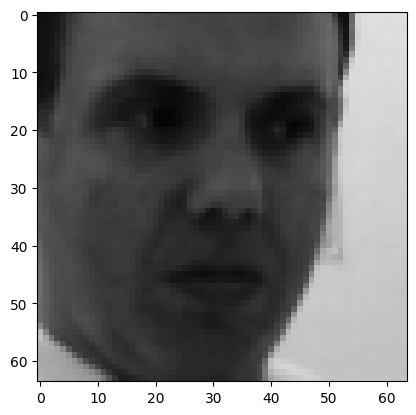

In [11]:
# Sample iterations
sample_loader = DataLoader(homogeneous_test_set, batch_size=1, shuffle=False)
sample_iter = iter(sample_loader)

# Uncomment/add more to iterate through the dataloader
# sample_img, sample_label = next(sample_iter)
# sample_img, sample_label = next(sample_iter)
# sample_img, sample_label = next(sample_iter)
# sample_img, sample_label = next(sample_iter)

sample_img, sample_label = next(sample_iter)
sample_img = sample_img.squeeze()
print(sample_img.shape)
plt.imshow(sample_img.numpy().transpose(1,2,0))
print(f'label: {sample_label.item()}, which maps to ' + label_map[sample_label.item()])

# Model

In [12]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [13]:
# Define custom CNN class for multiclass image classification
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.conv3 = nn.Conv2d(64, 128, 5, padding=2)

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(8192, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, len(label_map))

        # Define proportion of neurons to dropout to avoid overfitting
        self.pool_dropout = nn.Dropout(0.25)
        self.layer_dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = x.float()
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.pool_dropout(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.pool_dropout(x)

        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.pool_dropout(x)

        x = torch.flatten(x, 1)  # Flatten all dimensions except the batch
        x = F.relu(self.fc1(x))
        x = self.layer_dropout(x)
        x = F.relu(self.fc2(x))
        x = self.layer_dropout(x)
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

# Train and Test Functions

In [14]:
# Train function
def train(dataloader, model, optimizer, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0
    correct = 0
    model.train()

    for batch, (images, categories) in enumerate(dataloader):
        images, categories = images.to(device), categories.to(device)

        one_hot_categories = torch.nn.functional.one_hot(categories.long(), 18).float()


        optimizer.zero_grad()
        pred = model(images)
        loss = loss_fn(pred, one_hot_categories)
        loss.backward()
        optimizer.step()
        _, pred = torch.max(pred, 1)

        train_loss += loss.item()
        correct += sum(x == y for x, y in zip(pred, categories))

    average_train_loss = train_loss / num_batches
    accuracy = correct / size
    return accuracy, average_train_loss

In [15]:
# Test function
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
      for batch, (images, categories) in enumerate(dataloader):
          images, categories = images.to(device), categories.to(device)

          one_hot_categories = torch.nn.functional.one_hot(categories.long(), 18).float()

          pred = model(images)
          loss = loss_fn(pred, one_hot_categories)
          _, pred = torch.max(pred, 1)

          test_loss += loss.item()
          correct += sum(x == y for x, y in zip(pred, categories))

    average_test_loss = test_loss / num_batches
    accuracy = correct / size
    return accuracy, average_test_loss

In [16]:
BATCH_SIZE = 512

def train_model(train_set, valid_set, model, loss_fn, optim, epochs=100, print_status=True):
  # Define early stopping parameters
  patience = 5
  best_val_loss = float('inf')
  epochs_no_improve = 0

  # Return values
  train_accuracies = []
  train_losses = []
  valid_accuracies = []
  valid_losses = []

  for t in tqdm(range(epochs)):
      if print_status: print(f"Epoch {t+1}:")

      train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
      valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True)

      # train
      train_acc, train_loss = train(train_loader, model, optim, loss_fn)
      train_accuracies.append(train_acc)
      train_losses.append(train_loss)
      if print_status: print(f"\tAverage train accuracy: {100*train_acc:0.2f}%\t Avg train loss: {train_loss:>4f} \t")

      # test
      valid_acc, valid_loss = test(valid_loader, model, loss_fn)
      valid_accuracies.append(valid_acc)
      valid_losses.append(valid_loss)
      if print_status: print(f"\Validation accuracy: {100*valid_acc:0.2f}% \t Validation loss: {valid_loss:>4f}")

      # Check if validation loss has improved
      if valid_loss < best_val_loss:
          best_val_loss = valid_loss
          epochs_no_improve = 0
          # Save the model
          torch.save(model.state_dict(), 'best_model.pth')
      else:
          epochs_no_improve += 1

      # Check if early stopping criteria met
      if epochs_no_improve == patience:
          if print_status: print("No improvements, stopping earlier to avoid overfitting.")
          break

  return train_accuracies, train_losses, valid_accuracies, valid_losses

In [17]:
# Helper function to help plot accuracies
def plot_accuracies(train_accuracies, valid_accuracies, model_name):
    # Convert tensors to CPU if they are not already
    if isinstance(train_accuracies[0], torch.Tensor):
        train_accuracies = [x.cpu().detach().numpy() for x in train_accuracies]
    if isinstance(valid_accuracies[0], torch.Tensor):
        valid_accuracies = [x.cpu().detach().numpy() for x in valid_accuracies]

    epochs = range(1, len(train_accuracies) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accuracies, 'bo-', label='Training accuracy')
    plt.plot(epochs, valid_accuracies, 'ro-', label='Validation accuracy')
    plt.title(f'Training and Validation Accuracy for {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


In [18]:
RACE_GROUPS = {0: 'Black', 1: 'Indian', 2: 'East Asian', 3: 'Southeast Asian', 4: 'Middle Eastern', 5: 'Latino_Hispanic', 6: 'White', 7: 'All Race Groups'}

def test_all_race_groups(model, loss_fn):
  race_group_test_accuracies = []
  race_group_test_losses = []

  for idx, race in RACE_GROUPS.items():
    race_group_test_df = test_df[test_df['race'] == race] if idx != len(RACE_GROUPS)-1 else heterogeneous_test_df
    race_group_dataset = ImageDataset(data_frame=race_group_test_df)
    race_group_test_loader = DataLoader(race_group_dataset, batch_size=BATCH_SIZE, shuffle=True)

    test_acc, test_loss = test(race_group_test_loader, model, loss_fn)

    race_group_test_accuracies.append(test_acc)
    race_group_test_losses.append(test_loss)

  return race_group_test_accuracies, race_group_test_losses

In [19]:
# Plot double bar graph to compare accuracies
def plot_test_accuracies(homogeneous_test_accuracies, heterogeneous_test_accuracies):
  bar_width = 0.35
  index = np.arange(len(RACE_GROUPS))

  # Convert tensors to CPU if they are not already
  if isinstance(homogeneous_test_accuracies[0], torch.Tensor):
      homogeneous_test_accuracies = [x.cpu().detach().numpy() * 100 for x in homogeneous_test_accuracies]
  if isinstance(heterogeneous_test_accuracies[0], torch.Tensor):
      heterogeneous_test_accuracies = [x.cpu().detach().numpy() * 100 for x in heterogeneous_test_accuracies]

  plt.figure(figsize=(12, 6))

  plt.bar(index, homogeneous_test_accuracies, bar_width, label='Homogeneously Trained Model')
  plt.bar(index + bar_width, heterogeneous_test_accuracies, bar_width, label='Heterogeneously Tained Model')

  # Add labels and title
  plt.xlabel('Race Groups')
  plt.ylabel('Test Accuracy (%)')
  plt.title('Test Accuracies of Homogeneously vs Heterogeneously Trained Models by Race Groups')
  plt.xticks(index + bar_width / 2, RACE_GROUPS.values(), rotation=30)
  plt.legend()

  plt.show()

# Train Models

### Train Model Homogeneously

In [20]:
### TRAIN
# Create model for predicting age range of face based on homogeneous data
homogeneous_model = CNN().to(device)

homogeneous_optim = torch.optim.SGD(homogeneous_model.parameters(), lr=0.1, momentum=0.9)
homogeneous_loss = nn.CrossEntropyLoss()

# Randomize rows
randomized_df_homogeneous = homogeneous_train_df.sample(random_state=42069, frac=1)

# Split into Training and Validation Sets
train_size = int(0.9 * len(randomized_df_homogeneous))
random_homogeneous_train_set = randomized_df_homogeneous[:train_size]
random_homogeneous_validation_set = randomized_df_homogeneous[train_size:]

# homogeneous training data
transform = transforms.Compose([transforms.RandomHorizontalFlip(0.5)])

homogeneous_train_set = ImageDataset(data_frame=random_homogeneous_train_set, transform=transform)
homogeneous_valid_set = ImageDataset(data_frame=random_homogeneous_validation_set)

print(f"Homogeneous training set size: {len(homogeneous_train_set)}")
print(f"Homogeneous validation set size: {len(homogeneous_valid_set)}")

Homogeneous training set size: 14874
Homogeneous validation set size: 1653


In [21]:
# Train model
train_accuracies, train_losses, valid_accuracies, valid_losses = train_model(homogeneous_train_set, homogeneous_valid_set, homogeneous_model, homogeneous_loss, homogeneous_optim)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1:
	Average train accuracy: 15.99%	 Avg train loss: 2.594079 	


  1%|          | 1/100 [00:23<38:54, 23.58s/it]

\Validation accuracy: 17.54% 	 Validation loss: 2.491053
Epoch 2:
	Average train accuracy: 17.74%	 Avg train loss: 2.499447 	


  2%|▏         | 2/100 [00:46<37:53, 23.20s/it]

\Validation accuracy: 17.54% 	 Validation loss: 2.505110
Epoch 3:
	Average train accuracy: 17.81%	 Avg train loss: 2.499201 	


  3%|▎         | 3/100 [01:09<37:19, 23.09s/it]

\Validation accuracy: 17.60% 	 Validation loss: 2.507693
Epoch 4:
	Average train accuracy: 17.82%	 Avg train loss: 2.498595 	


  4%|▍         | 4/100 [01:33<37:22, 23.36s/it]

\Validation accuracy: 17.54% 	 Validation loss: 2.504064
Epoch 5:
	Average train accuracy: 18.43%	 Avg train loss: 2.477531 	


  5%|▌         | 5/100 [01:55<36:17, 22.92s/it]

\Validation accuracy: 14.88% 	 Validation loss: 2.491983
Epoch 6:
	Average train accuracy: 18.50%	 Avg train loss: 2.463645 	


  6%|▌         | 6/100 [02:19<36:37, 23.38s/it]

\Validation accuracy: 21.66% 	 Validation loss: 2.430861
Epoch 7:
	Average train accuracy: 20.42%	 Avg train loss: 2.434349 	


  7%|▋         | 7/100 [02:42<36:05, 23.28s/it]

\Validation accuracy: 21.11% 	 Validation loss: 2.432523
Epoch 8:
	Average train accuracy: 20.18%	 Avg train loss: 2.413623 	


  8%|▊         | 8/100 [03:04<35:07, 22.91s/it]

\Validation accuracy: 21.78% 	 Validation loss: 2.387886
Epoch 9:
	Average train accuracy: 22.03%	 Avg train loss: 2.360904 	


  9%|▉         | 9/100 [03:27<34:48, 22.95s/it]

\Validation accuracy: 19.48% 	 Validation loss: 2.412141
Epoch 10:
	Average train accuracy: 22.91%	 Avg train loss: 2.297654 	


 10%|█         | 10/100 [03:52<35:15, 23.51s/it]

\Validation accuracy: 24.86% 	 Validation loss: 2.236966
Epoch 11:
	Average train accuracy: 24.28%	 Avg train loss: 2.249275 	


 11%|█         | 11/100 [04:15<34:28, 23.24s/it]

\Validation accuracy: 23.71% 	 Validation loss: 2.284781
Epoch 12:
	Average train accuracy: 24.44%	 Avg train loss: 2.204291 	


 12%|█▏        | 12/100 [04:38<33:53, 23.10s/it]

\Validation accuracy: 21.29% 	 Validation loss: 2.241962
Epoch 13:
	Average train accuracy: 25.79%	 Avg train loss: 2.165624 	


 13%|█▎        | 13/100 [05:01<33:34, 23.16s/it]

\Validation accuracy: 26.80% 	 Validation loss: 2.102431
Epoch 14:
	Average train accuracy: 27.65%	 Avg train loss: 2.106558 	


 14%|█▍        | 14/100 [05:24<33:13, 23.18s/it]

\Validation accuracy: 27.47% 	 Validation loss: 2.080606
Epoch 15:
	Average train accuracy: 27.65%	 Avg train loss: 2.091523 	


 15%|█▌        | 15/100 [05:47<32:38, 23.04s/it]

\Validation accuracy: 27.53% 	 Validation loss: 2.088209
Epoch 16:
	Average train accuracy: 28.22%	 Avg train loss: 2.055370 	


 16%|█▌        | 16/100 [06:11<32:43, 23.37s/it]

\Validation accuracy: 28.55% 	 Validation loss: 2.070138
Epoch 17:
	Average train accuracy: 29.39%	 Avg train loss: 2.021830 	


 17%|█▋        | 17/100 [06:34<32:20, 23.38s/it]

\Validation accuracy: 28.37% 	 Validation loss: 2.077287
Epoch 18:
	Average train accuracy: 29.72%	 Avg train loss: 2.005694 	


 18%|█▊        | 18/100 [06:58<31:54, 23.35s/it]

\Validation accuracy: 26.01% 	 Validation loss: 2.125410
Epoch 19:
	Average train accuracy: 29.21%	 Avg train loss: 2.014021 	


 19%|█▉        | 19/100 [07:21<31:43, 23.50s/it]

\Validation accuracy: 30.85% 	 Validation loss: 1.974142
Epoch 20:
	Average train accuracy: 31.05%	 Avg train loss: 1.976948 	


 20%|██        | 20/100 [07:44<31:08, 23.35s/it]

\Validation accuracy: 31.40% 	 Validation loss: 1.923327
Epoch 21:
	Average train accuracy: 31.50%	 Avg train loss: 1.928878 	


 21%|██        | 21/100 [08:08<30:38, 23.27s/it]

\Validation accuracy: 31.64% 	 Validation loss: 1.984585
Epoch 22:
	Average train accuracy: 32.93%	 Avg train loss: 1.897043 	


 22%|██▏       | 22/100 [08:31<30:20, 23.34s/it]

\Validation accuracy: 30.91% 	 Validation loss: 1.941552
Epoch 23:
	Average train accuracy: 32.26%	 Avg train loss: 1.871347 	


 23%|██▎       | 23/100 [08:54<29:37, 23.08s/it]

\Validation accuracy: 30.85% 	 Validation loss: 1.958964
Epoch 24:
	Average train accuracy: 33.45%	 Avg train loss: 1.862183 	


 24%|██▍       | 24/100 [09:17<29:20, 23.16s/it]

\Validation accuracy: 33.70% 	 Validation loss: 1.870895
Epoch 25:
	Average train accuracy: 34.42%	 Avg train loss: 1.824395 	


 25%|██▌       | 25/100 [09:41<29:26, 23.55s/it]

\Validation accuracy: 30.61% 	 Validation loss: 1.902541
Epoch 26:
	Average train accuracy: 34.24%	 Avg train loss: 1.835183 	


 26%|██▌       | 26/100 [10:05<28:56, 23.47s/it]

\Validation accuracy: 29.89% 	 Validation loss: 2.016828
Epoch 27:
	Average train accuracy: 35.40%	 Avg train loss: 1.801624 	


 27%|██▋       | 27/100 [10:27<28:13, 23.21s/it]

\Validation accuracy: 35.15% 	 Validation loss: 1.836237
Epoch 28:
	Average train accuracy: 36.07%	 Avg train loss: 1.756744 	


 28%|██▊       | 28/100 [10:52<28:21, 23.63s/it]

\Validation accuracy: 33.70% 	 Validation loss: 1.807816
Epoch 29:
	Average train accuracy: 35.37%	 Avg train loss: 1.764106 	


 29%|██▉       | 29/100 [11:15<27:49, 23.52s/it]

\Validation accuracy: 34.18% 	 Validation loss: 1.823549
Epoch 30:
	Average train accuracy: 36.33%	 Avg train loss: 1.735439 	


 30%|███       | 30/100 [11:39<27:30, 23.57s/it]

\Validation accuracy: 34.54% 	 Validation loss: 1.829530
Epoch 31:
	Average train accuracy: 37.54%	 Avg train loss: 1.712429 	


 31%|███       | 31/100 [12:01<26:44, 23.26s/it]

\Validation accuracy: 33.51% 	 Validation loss: 1.837686
Epoch 32:
	Average train accuracy: 36.65%	 Avg train loss: 1.734546 	


 32%|███▏      | 32/100 [12:25<26:24, 23.31s/it]

\Validation accuracy: 34.30% 	 Validation loss: 1.839965
Epoch 33:
	Average train accuracy: 38.10%	 Avg train loss: 1.703204 	


 32%|███▏      | 32/100 [12:48<27:13, 24.02s/it]

\Validation accuracy: 32.30% 	 Validation loss: 1.908653
No improvements, stopping earlier to avoid overfitting.


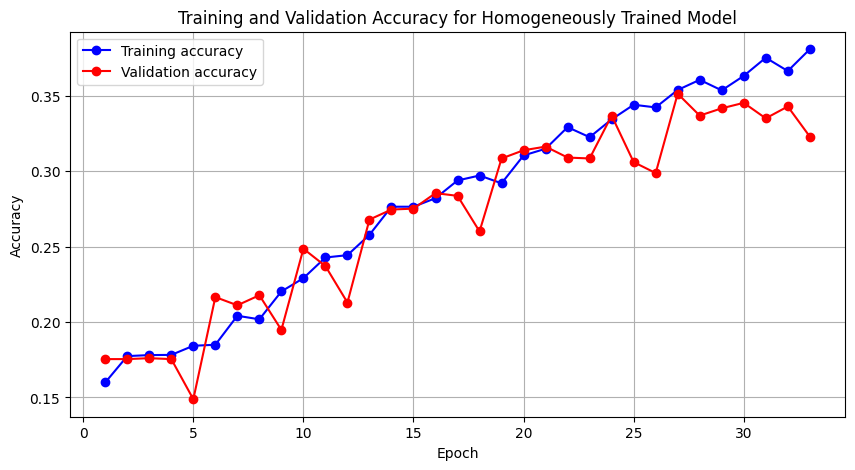

In [22]:
# Plot accuracies accross epochs
plot_accuracies(train_accuracies, valid_accuracies, 'Homogeneously Trained Model')

### Train Model Heterogeneously

In [23]:
### TRAIN
# Initialize model
heterogeneous_model = CNN().to(device)
heterogeneous_optim = torch.optim.SGD(heterogeneous_model.parameters(), lr=0.1, momentum=0.9)
heterogeneous_loss = nn.CrossEntropyLoss()


# Randomize rows
randomized_df_heterogeneous = heterogeneous_train_df.sample(random_state=42069, frac=1)

# Split into Training and Validation Sets
train_size = int(0.9 * len(randomized_df_heterogeneous))
random_heterogeneous_train_set = randomized_df_heterogeneous[:train_size]
random_heterogeneous_validation_set = randomized_df_heterogeneous[train_size:]

# homogeneous training data
transform = transforms.Compose([transforms.RandomHorizontalFlip(0.5)])

heterogeneous_train_set = ImageDataset(data_frame=random_heterogeneous_train_set, transform=transform)
heterogeneous_valid_set = ImageDataset(data_frame=random_heterogeneous_validation_set)

print(f"Heterogeneous training set size: {len(heterogeneous_train_set)}")
print(f"Heterogeneous validation set size: {len(heterogeneous_valid_set)}")

Heterogeneous training set size: 78069
Heterogeneous validation set size: 8675


In [24]:
# Train model
train_accuracies, train_losses, valid_accuracies, valid_losses = train_model(heterogeneous_train_set, heterogeneous_valid_set, heterogeneous_model, heterogeneous_loss, heterogeneous_optim)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1:
	Average train accuracy: 16.42%	 Avg train loss: 2.552407 	


  1%|          | 1/100 [02:04<3:25:58, 124.84s/it]

\Validation accuracy: 18.96% 	 Validation loss: 2.497532
Epoch 2:
	Average train accuracy: 22.35%	 Avg train loss: 2.352501 	


  2%|▏         | 2/100 [04:07<3:21:25, 123.32s/it]

\Validation accuracy: 28.37% 	 Validation loss: 2.120643
Epoch 3:
	Average train accuracy: 28.63%	 Avg train loss: 2.077894 	


  3%|▎         | 3/100 [06:09<3:18:49, 122.98s/it]

\Validation accuracy: 31.40% 	 Validation loss: 1.957385
Epoch 4:
	Average train accuracy: 31.86%	 Avg train loss: 1.928020 	


  4%|▍         | 4/100 [08:11<3:15:44, 122.34s/it]

\Validation accuracy: 36.30% 	 Validation loss: 1.768805
Epoch 5:
	Average train accuracy: 34.25%	 Avg train loss: 1.829688 	


  5%|▌         | 5/100 [10:13<3:13:33, 122.24s/it]

\Validation accuracy: 35.57% 	 Validation loss: 1.729501
Epoch 6:
	Average train accuracy: 35.89%	 Avg train loss: 1.765019 	


  6%|▌         | 6/100 [12:15<3:11:45, 122.40s/it]

\Validation accuracy: 38.81% 	 Validation loss: 1.642239
Epoch 7:
	Average train accuracy: 37.18%	 Avg train loss: 1.710678 	


  7%|▋         | 7/100 [14:18<3:10:01, 122.60s/it]

\Validation accuracy: 40.77% 	 Validation loss: 1.584483
Epoch 8:
	Average train accuracy: 37.90%	 Avg train loss: 1.680717 	


  8%|▊         | 8/100 [16:27<3:11:04, 124.62s/it]

\Validation accuracy: 42.07% 	 Validation loss: 1.547571
Epoch 9:
	Average train accuracy: 39.02%	 Avg train loss: 1.637351 	


  9%|▉         | 9/100 [18:31<3:08:32, 124.32s/it]

\Validation accuracy: 40.52% 	 Validation loss: 1.587104
Epoch 10:
	Average train accuracy: 39.73%	 Avg train loss: 1.617960 	


 10%|█         | 10/100 [20:34<3:05:49, 123.89s/it]

\Validation accuracy: 40.29% 	 Validation loss: 1.585221
Epoch 11:
	Average train accuracy: 40.14%	 Avg train loss: 1.598476 	


 11%|█         | 11/100 [22:44<3:06:37, 125.81s/it]

\Validation accuracy: 39.78% 	 Validation loss: 1.589121
Epoch 12:
	Average train accuracy: 40.53%	 Avg train loss: 1.582864 	


 12%|█▏        | 12/100 [24:58<3:07:57, 128.15s/it]

\Validation accuracy: 41.52% 	 Validation loss: 1.516466
Epoch 13:
	Average train accuracy: 41.19%	 Avg train loss: 1.566327 	


 13%|█▎        | 13/100 [27:02<3:04:09, 127.01s/it]

\Validation accuracy: 42.66% 	 Validation loss: 1.506851
Epoch 14:
	Average train accuracy: 41.76%	 Avg train loss: 1.541415 	


 14%|█▍        | 14/100 [29:03<2:59:34, 125.28s/it]

\Validation accuracy: 42.43% 	 Validation loss: 1.494413
Epoch 15:
	Average train accuracy: 41.99%	 Avg train loss: 1.536395 	


 15%|█▌        | 15/100 [31:04<2:55:36, 123.96s/it]

\Validation accuracy: 43.25% 	 Validation loss: 1.485359
Epoch 16:
	Average train accuracy: 41.99%	 Avg train loss: 1.530113 	


 16%|█▌        | 16/100 [33:04<2:51:55, 122.80s/it]

\Validation accuracy: 42.04% 	 Validation loss: 1.500499
Epoch 17:
	Average train accuracy: 42.82%	 Avg train loss: 1.507603 	


 17%|█▋        | 17/100 [35:03<2:48:18, 121.67s/it]

\Validation accuracy: 43.65% 	 Validation loss: 1.484324
Epoch 18:
	Average train accuracy: 42.67%	 Avg train loss: 1.505738 	


 18%|█▊        | 18/100 [37:06<2:46:44, 122.00s/it]

\Validation accuracy: 43.03% 	 Validation loss: 1.466574
Epoch 19:
	Average train accuracy: 43.34%	 Avg train loss: 1.489629 	


 19%|█▉        | 19/100 [39:08<2:44:36, 121.93s/it]

\Validation accuracy: 44.09% 	 Validation loss: 1.470065
Epoch 20:
	Average train accuracy: 43.38%	 Avg train loss: 1.481137 	


 20%|██        | 20/100 [41:10<2:42:48, 122.10s/it]

\Validation accuracy: 43.39% 	 Validation loss: 1.480100
Epoch 21:
	Average train accuracy: 43.35%	 Avg train loss: 1.480933 	


 21%|██        | 21/100 [43:13<2:41:09, 122.39s/it]

\Validation accuracy: 42.96% 	 Validation loss: 1.476578
Epoch 22:
	Average train accuracy: 43.68%	 Avg train loss: 1.470386 	


 22%|██▏       | 22/100 [45:13<2:38:11, 121.69s/it]

\Validation accuracy: 43.67% 	 Validation loss: 1.468227
Epoch 23:
	Average train accuracy: 44.01%	 Avg train loss: 1.460992 	


 22%|██▏       | 22/100 [47:13<2:47:27, 128.82s/it]

\Validation accuracy: 42.41% 	 Validation loss: 1.517530
No improvements, stopping earlier to avoid overfitting.


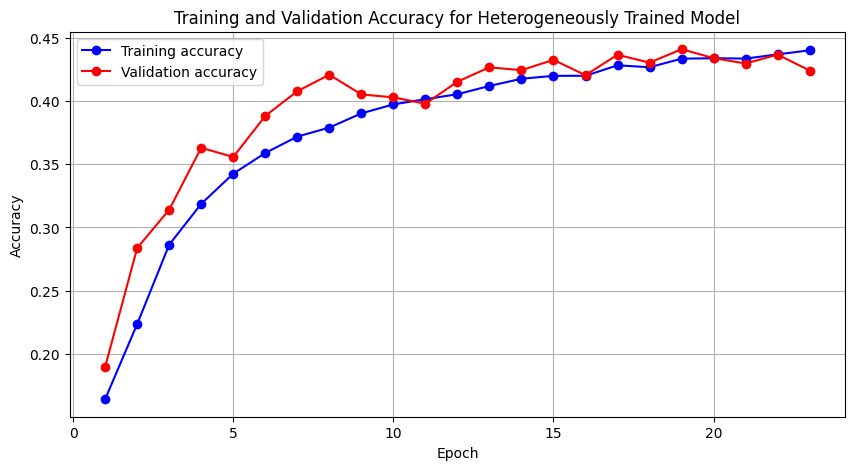

In [25]:
# Plot accuracies accross epochs
plot_accuracies(train_accuracies, valid_accuracies, 'Heterogeneously Trained Model')

# Test Trained Models

In [26]:
### TEST
homogeneous_race_accs, _ = test_all_race_groups(homogeneous_model, homogeneous_loss)
heterogeneous_race_accs, _ = test_all_race_groups(heterogeneous_model, heterogeneous_loss)

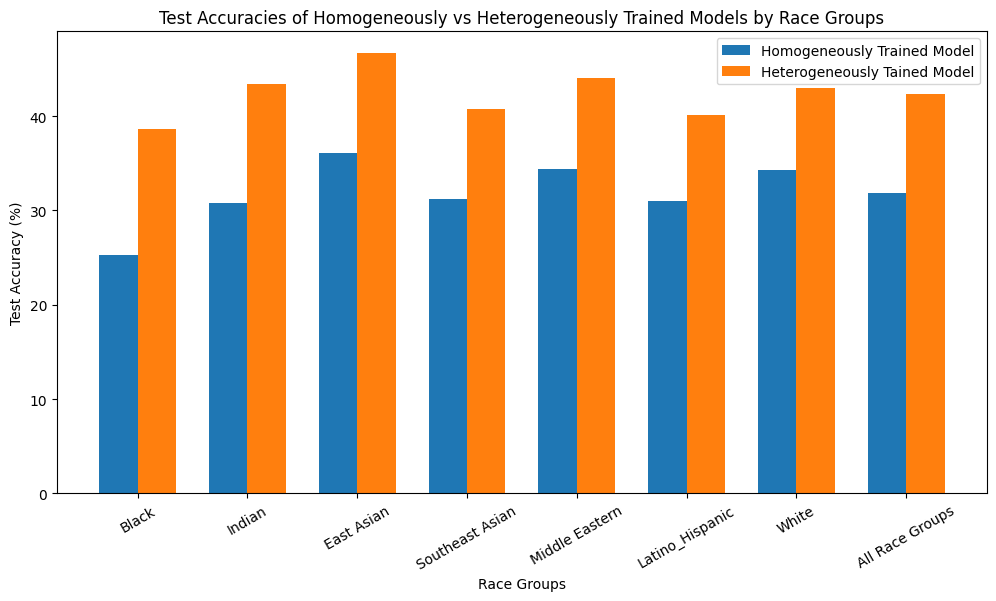

In [27]:
plot_test_accuracies(homogeneous_race_accs, heterogeneous_race_accs)

# Display Learned Features

In [28]:
def display_features(model, model_name):
    num_filters = model.conv3.weight.shape[0]

    num_cols = 16
    num_rows = (num_filters + num_cols - 1) // num_cols

    plt.figure(figsize=(16, num_rows))
    for i in range(num_filters):
        plt.subplot(num_rows, num_cols, i+1)
        filter_weights = model.conv3.weight[i][0].cpu().detach().numpy()
        plt.imshow(filter_weights, cmap='gray', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])

    plt.tight_layout()
    plt.suptitle(f'Final features extracted by {model_name}', fontsize=16, y=1.02)
    plt.show()

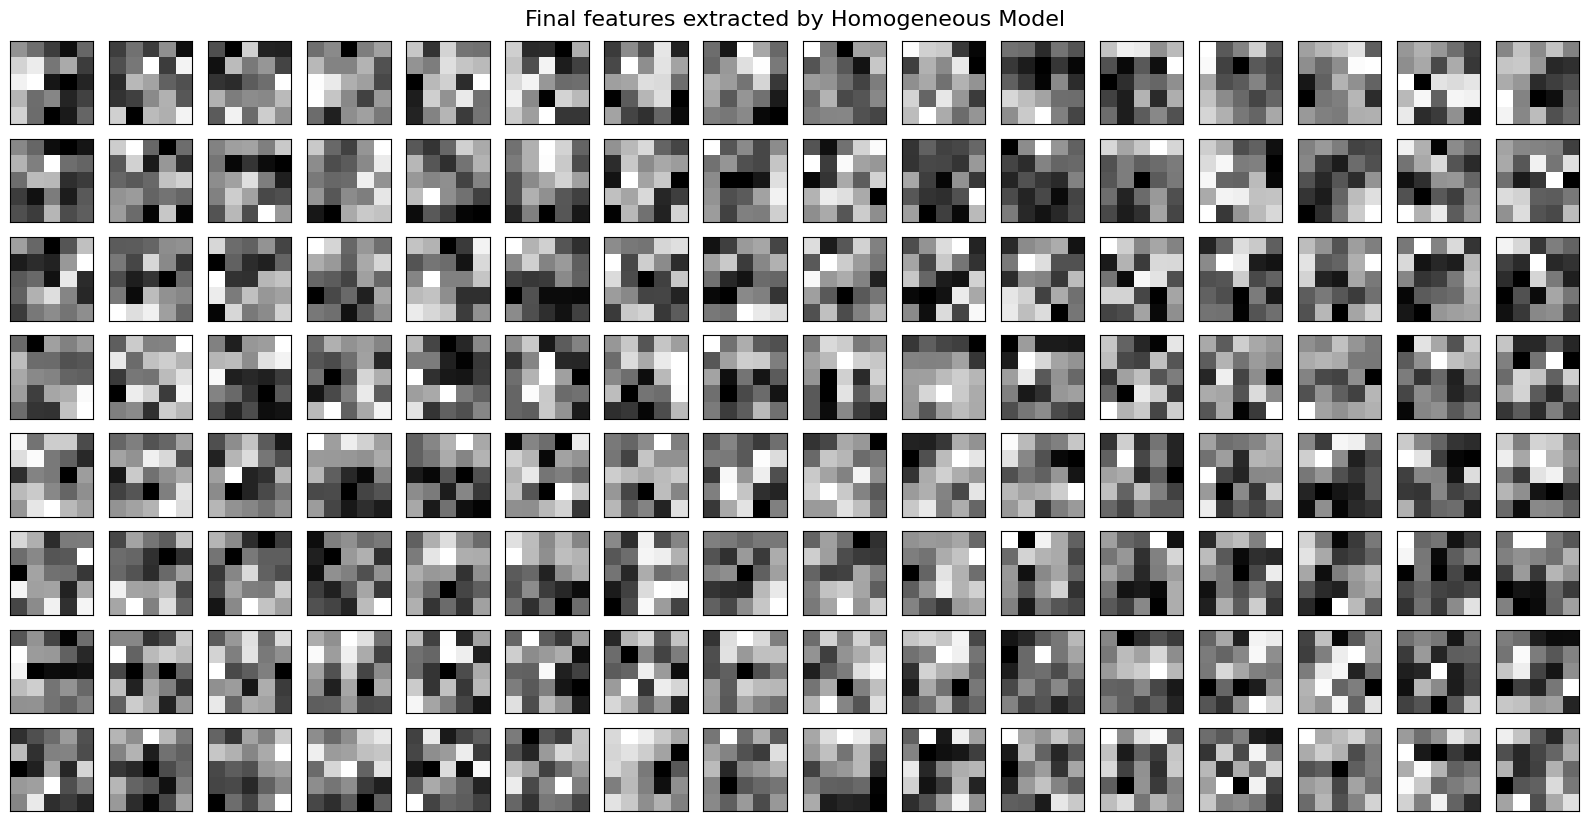

In [31]:
# Final features extracted by homogeneous model
display_features(homogeneous_model, "Homogeneous Model")

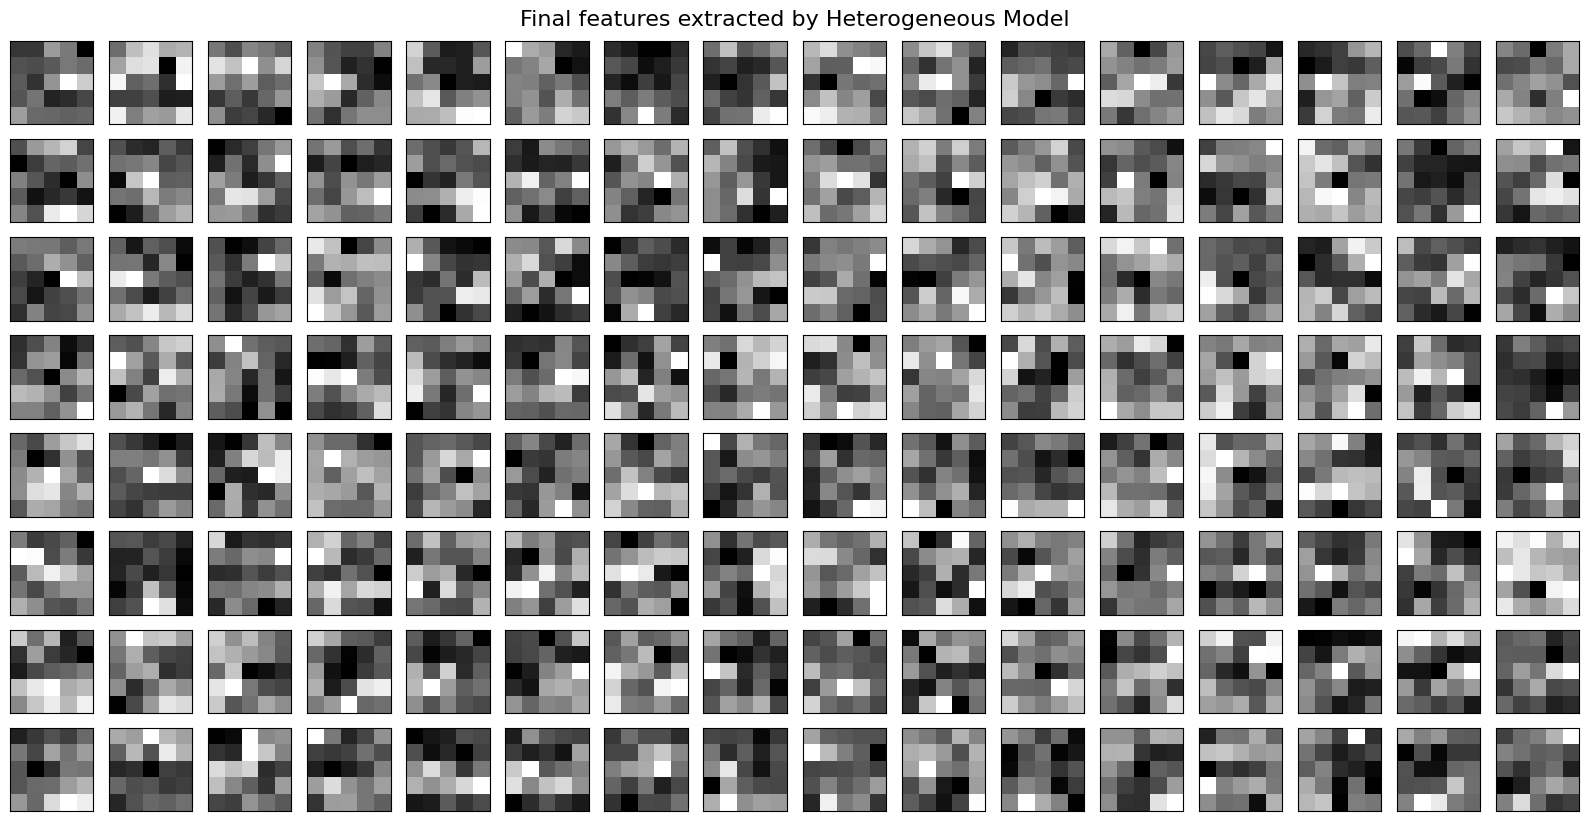

In [30]:
# Final features extracted by heterogeneous model
display_features(heterogeneous_model, "Heterogeneous Model")